In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# import tensorflow and check for gpu
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import pickle 

# import with pickle
filename = 'gdrive/My Drive/MosquitoNet/mosquito_dataset.pkl'
infile = open(filename,'rb')
dataset = pickle.load(infile)
infile.close()

In [10]:
# extract headlegs images from dictionary
x_full = [np.array(example["headlegs"]) for example in dataset]
x_full.extend([np.array(example["wings"]) for example in dataset])
x_full.extend([np.array(example["palps"]) for example in dataset])
y_full = [np.array(example["label"]) for example in dataset]
y_full.extend([np.array(example["label"]) for example in dataset])
y_full.extend([np.array(example["label"]) for example in dataset])

### one-hot encoding ###
# create one-hot label vectors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_full)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_full_onehot = onehot_encoder.fit_transform(integer_encoded)

# # invert first example
# inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
# print(onehot_encoded[0, :])
# print(inverted)

# one-hot encoding with ONLY sklearn OneHotEncolder
# onehotencoder = OneHotEncoder()
# y_train_onehot = onehotencoder.fit_transform(y_train.reshape(-1,1)).toarray()
# y_test_onehot = onehotencoder.fit_transform(y_test.reshape(-1,1)).toarray()

### train-test splits ###
# create splits
from  sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full_onehot, test_size=0.2, shuffle=True, random_state=0)

# convert to numpy array
x_train = np.array([np.array(el) for el in x_train])
x_test = np.array([np.array(el) for el in x_test])
y_train = np.array([np.array(el) for el in y_train])
y_test = np.array([np.array(el) for el in y_test])

# print summary
print('x_full: ' + str(len(x_full)) + ' samples, type: ' + str(type(x_full)))
print('y_full: ' + str(len(y_full)) + ' samples, type: ' + str(type(y_full)))
print('x_train: ' + str(len(x_train)) + ' samples, shape: ' + str(x_train.shape))
print('y_train: ' + str(len(y_train)) + ' samples, shape: ' + str(y_train.shape))
print('x_test: ' + str(len(x_test)) + ' samples, shape: ' + str(x_test.shape))
print('y_test: ' + str(len(y_test)) + ' samples, shape: ' + str(y_test.shape))

x_full: 3981 samples, type: <class 'list'>
y_full: 3981 samples, type: <class 'list'>
x_train: 3184 samples, shape: (3184, 224, 224, 3)
y_train: 3184 samples, shape: (3184, 4)
x_test: 797 samples, shape: (797, 224, 224, 3)
y_test: 797 samples, shape: (797, 4)


In [0]:
# preprocess dataset with keras
from tensorflow import keras

# create ImageDataGenerator instances for train & test
train_datagen = keras.preprocessing.image.ImageDataGenerator()
test_datagen = keras.preprocessing.image.ImageDataGenerator()

# create generators
BATCH_SIZE = 32
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

In [11]:
# oversample the training dataset
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
# oversample the datasets by creating BalancedDataGenerators
train_balgen = BalancedDataGenerator(x_train, y_train, train_datagen, batch_size=32)
STEPS_PER_EPOCH_TRAIN = train_balgen.steps_per_epoch

test_balgen = BalancedDataGenerator(x_test, y_test, test_datagen, batch_size=32)
STEPS_PER_EPOCH_TEST = test_balgen.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Fine-tune InceptionV3 on a new set of classes**

https://keras.io/applications/

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [16]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
# STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 5
history_toptraining = model.fit(
    train_balgen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_data=test_balgen,
    validation_steps=STEPS_PER_EPOCH_TEST
)

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


177/177 [==============================] - 29s 164ms/step - loss: 1.7394 - accuracy: 0.2947 - val_loss: 1.5595 - val_accuracy: 0.2592
Epoch 2/5
177/177 [==============================] - 17s 95ms/step - loss: 1.3564 - accuracy: 0.3709 - val_loss: 1.6965 - val_accuracy: 0.2507
Epoch 3/5
177/177 [==============================] - 16s 93ms/step - loss: 1.2457 - accuracy: 0.4442 - val_loss: 1.7425 - val_accuracy: 0.2514
Epoch 4/5
177/177 [==============================] - 16s 93ms/step - loss: 1.1377 - accuracy: 0.5125 - val_loss: 2.7658 - val_accuracy: 0.2665
Epoch 5/5
177/177 [==============================] - 16s 93ms/step - loss: 1.0028 - accuracy: 0.5761 - val_loss: 2.6982 - val_accuracy: 0.2708


In [17]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [18]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_finetuning = model.fit(
    train_balgen,
    epochs=10,
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_data=test_balgen,
    validation_steps=STEPS_PER_EPOCH_TEST
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
177/177 [==============================] - 27s 151ms/step - loss: 0.8138 - accuracy: 0.7152 - val_loss: 2.4399 - val_accuracy: 0.2693
Epoch 2/10
177/177 [==============================] - 19s 109ms/step - loss: 0.6763 - accuracy: 0.7952 - val_loss: 1.7567 - val_accuracy: 0.2629
Epoch 3/10
177/177 [==============================] - 19s 109ms/step - loss: 0.5808 - accuracy: 0.8416 - val_loss: 2.6234 - val_accuracy: 0.2643
Epoch 4/10
177/177 [==============================] - 19s 108ms/step - loss: 0.4976 - accuracy: 0.8819 - val_loss: 2.3216 - val_accuracy: 0.2665
Epoch 5/10
177/177 [==============================] - 19s 108ms/step - loss: 0.4241 - accuracy: 0.9115 - val_loss: 3.2847 - val_accuracy: 0.2708
Epoch 6/10
177/177 [==============================] - 19s 109ms/step - loss: 0.3590 - accuracy: 0.9419 - val_loss: 2.9846 - val_accuracy: 0.2658
Epoch 7/10
177/177 [==============================] - 19s 108ms/step - loss: 0.3018 - accuracy: 0.9599 - val_loss: 2.5150 - val_ac

In [0]:
def visualize_training(history, filename):
  plt.figure(figsize=(15,5))

  # plot training & validation loss values
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss vs. Epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # plot training & validation accuracy values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy vs. Epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # show plot
  plt.savefig(filename)
  plt.show()

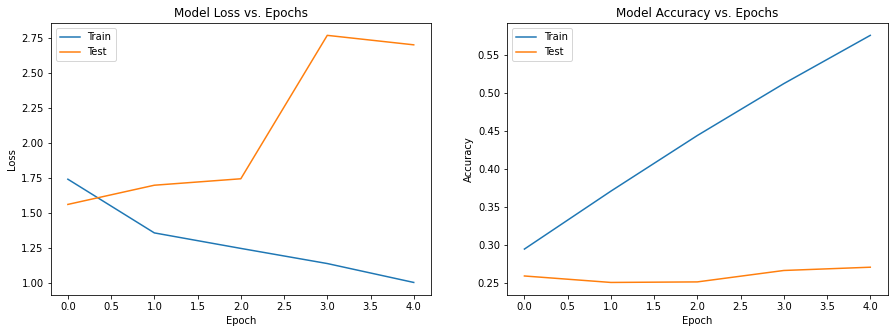

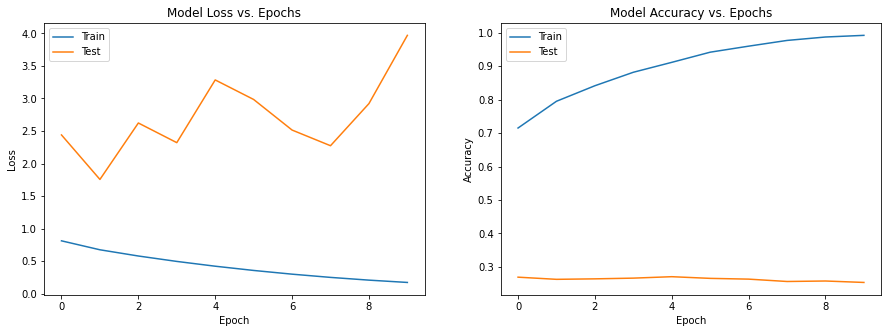

In [26]:
visualize_training(history_toptraining, 'gdrive/My Drive/MosquitoNet/figures/inceptionv3_full_oversample_toptraining.png')
visualize_training(history_finetuning, 'gdrive/My Drive/MosquitoNet/figures/inceptionv3_full_oversample_finetuning.png')

In [0]:
# function to reset model weights (use in between training runs)
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, filename=None):
  if normalize:
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.savefig(filename)
  plt.show()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# get predictions
y_pred_raw = model.predict_generator(test_generator, len(x_test) // BATCH_SIZE+1)
y_pred = np.argmax(y_pred_raw, axis=1)

# get actual classes
y_test_inverted = [np.argmax(val) for val in y_test]

# generate confusion matrix
cm = confusion_matrix(y_test_inverted, y_pred)

# get target names
target_names = label_encoder.inverse_transform(np.arange(0,4))

# generate plot
plot_confusion_matrix(cm, target_names, normalize=False, filename='gdrive/My Drive/MosquitoNet/figures/inceptionv3_full_oversample_confusionmatrix.png')

ValueError: ignored

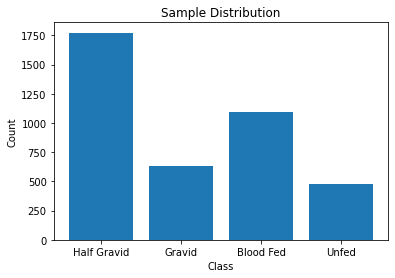

In [0]:
y_full = np.array(y_full, dtype=str)

# check class distribution
from collections import Counter
unique_classes = list(Counter(y_full).keys()) # equals to list(set(words))
class_counts = list(Counter(y_full).values()) # counts the elements' frequency

# make bar graph
x = np.arange(len(unique_classes))
plt.bar(x, class_counts)
plt.xticks(x, tuple(unique_classes))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Sample Distribution')
plt.savefig('gdrive/My Drive/MosquitoNet/figures/inceptionv3_full_oversample_sampledist.png')
plt.show()